# Tutorial CV3 - Function fitting with a quantum neural network

In this tutorial we show how a variational circuit can be used to extrapolate a one-dimensional function when being trained with noisy samples from that function. 

The variational circuit we use is the continuous-variable quantum neural network model described in Killoran et al. 2018 (arxiv 1806.06871). 

### Imports

This time we will use the Adam optimizer. 

*Note: For convenience, we use openqml's numpy library for all numpy processing. Strictly speaking, one only needs this library for numpy operations inside the cost function or functions called therein, and can use numpy imported via the usual `import numpy as np` everywhere else.*

In [1]:
import openqml as qm
from openqml import numpy as np
from openqml.optimize import AdamOptimizer

The device is again the StrawberryFields simulator, this time with only one quantum mode or "wire".

In [2]:
dev = qm.device('strawberryfields.fock', wires=1, cutoff_dim=10)

### Quantum node

A single mode layer of the variational circuit is defined as:

In [3]:
def layer(w):

    # Matrix multiplication of input layer
    qm.Rotation(w[0], [0])
    qm.Squeezing(w[1], 0., [0])
    qm.Rotation(w[2], [0])

    # Bias
    qm.Displacement(w[3], 0., [0])

    # Element-wise nonlinear transformation
    qm.Kerr(w[4], [0])

The variational circuit in the quantum node first encodes the input into the displacement of the mode, and then executes the layers. The output is the expectation of the x-quadrature.

In [4]:
@qm.qnode(dev)
def quantum_neural_net(weights, x=None):
    
    # Encode input x into quantum state
    qm.Displacement(x, 0., [0])

    # execute "layers"
    for w in weights:
        layer(w)

    return qm.expval.X(0)

### Objective

As an objective we take the square loss between target labels and model predictions.

In [5]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l-p)**2
    loss = loss/len(labels)

    return loss

In the cost function, we compute the outputs from the variational circuit. Function fitting is a regression problem, and we interpret the expectations from the quantum node as predictions (i.e. without applying postprocessing such as thresholding).

In [6]:
def cost(weights, features, labels):

    preds = [quantum_neural_net(weights, x=x) for x in features]

    return square_loss(labels, preds)

### Optimization

We load noisy data samples of a sine function.

In [7]:
data = np.loadtxt("sine.txt")
X = data[:, 0]
Y = data[:, 1]

The data looks as follows. 

*Note: For the next cell to work you need python's matplotlib library.* 

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, Y)
plt.xlabel('x', fontsize=18)
plt.ylabel('f(x)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

<Figure size 640x480 with 1 Axes>

The network's weights, which we call variables here, are initialized with values sampled from a normal distribution. We use 4 layers, although performance has been found to plateau at around 6 layers.

In [9]:
num_layers = 4
vars_init = 0.05*np.random.randn(num_layers, 7)

vars_init

array([[-0.03482101, -0.05767631, -0.04485433, -0.06611208, -0.02813008,
        -0.01256533,  0.03749971],
       [ 0.11739055, -0.04323136,  0.07451296,  0.07704561, -0.05992899,
        -0.02748394, -0.06371672],
       [-0.00261234,  0.03510685,  0.03453766, -0.08888558, -0.05174211,
        -0.03829791,  0.00115854],
       [-0.04261771,  0.0107052 , -0.12688993,  0.00335811,  0.046572  ,
         0.03462589,  0.07121722]])

We choose the Adam optimizer and update the weights for 10 steps.

In [10]:
o = AdamOptimizer(0.005, beta1=0.9, beta2=0.999)

vars = vars_init
for it in range(10):
    vars = o.step(lambda v: cost(v, X, Y), vars)
    
    print("Iter: {:5d} | Cost: {:0.7f} | Mean of abs vars: {:0.7f}"
          .format(it+1, cost(vars, X, Y), np.mean(np.abs(vars))))

Iter:     1 | Cost: 0.3613590 | Mean of abs vars: 0.0478436
Iter:     2 | Cost: 0.3480233 | Mean of abs vars: 0.0480128
Iter:     3 | Cost: 0.3366658 | Mean of abs vars: 0.0481594
Iter:     4 | Cost: 0.3264126 | Mean of abs vars: 0.0482944
Iter:     5 | Cost: 0.3168581 | Mean of abs vars: 0.0484228
Iter:     6 | Cost: 0.3077773 | Mean of abs vars: 0.0485474
Iter:     7 | Cost: 0.2990315 | Mean of abs vars: 0.0486699
Iter:     8 | Cost: 0.2905294 | Mean of abs vars: 0.0487915
Iter:     9 | Cost: 0.2822090 | Mean of abs vars: 0.0489129
Iter:    10 | Cost: 0.2740273 | Mean of abs vars: 0.0490349


We can continue training for another 50 steps (although this takes some time).

In [11]:
for it in range(40):
    vars = o.step(lambda v: cost(v, X, Y), vars)
    
    print("Iter: {:5d} | Cost: {:0.7f} | Mean of abs vars: {:0.7f}"
          .format(it+11, cost(vars, X, Y), np.mean(np.abs(vars))))

Iter:    11 | Cost: 0.2659547 | Mean of abs vars: 0.0491577
Iter:    12 | Cost: 0.2579718 | Mean of abs vars: 0.0492818
Iter:    13 | Cost: 0.2500669 | Mean of abs vars: 0.0494073
Iter:    14 | Cost: 0.2422346 | Mean of abs vars: 0.0495344
Iter:    15 | Cost: 0.2344747 | Mean of abs vars: 0.0496632
Iter:    16 | Cost: 0.2267917 | Mean of abs vars: 0.0497938
Iter:    17 | Cost: 0.2191939 | Mean of abs vars: 0.0499261
Iter:    18 | Cost: 0.2116926 | Mean of abs vars: 0.0500601
Iter:    19 | Cost: 0.2043026 | Mean of abs vars: 0.0501957
Iter:    20 | Cost: 0.1970406 | Mean of abs vars: 0.0503329
Iter:    21 | Cost: 0.1899257 | Mean of abs vars: 0.0504715
Iter:    22 | Cost: 0.1829784 | Mean of abs vars: 0.0506113
Iter:    23 | Cost: 0.1762202 | Mean of abs vars: 0.0507522
Iter:    24 | Cost: 0.1696736 | Mean of abs vars: 0.0508939
Iter:    25 | Cost: 0.1633609 | Mean of abs vars: 0.0510360
Iter:    26 | Cost: 0.1573042 | Mean of abs vars: 0.0511785
Iter:    27 | Cost: 0.1515243 | Mean of 

Finally, we collect the predictions of the trained model for 50 values in $[-1,1]$...

In [17]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(vars, x=x_) for x_ in x_pred]

...and plot the shape of the function that the model has "learned" from the noisy data (green dots).

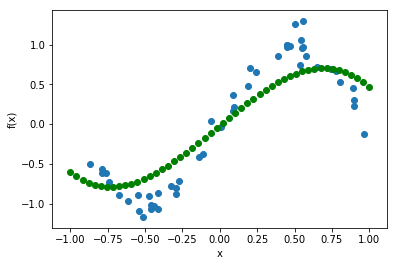

In [22]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color='green')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()

The model has learned to smoothen the noisy data.

In fact, we can use openqml to look at typical functions that the model produces without being trained at all. The shape of these functions varies significantly with the variance hyperparameter for the weight initialization. 

Setting this hyperparameter to a small value produces almost linear functions, since all quantum gates in the variational circuit are almost performing an identity. Larger values produces smoothly oscillating functions with a period that depends on the number of layers used (the more layers the smaller the period).

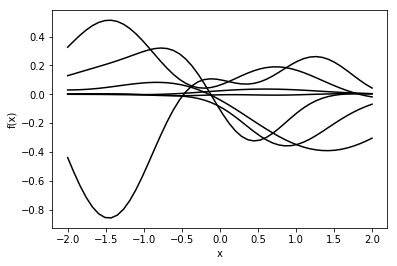

In [29]:
variance = 1.

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_vars = variance*np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_vars, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color='black')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()